In [1]:
# Julia 1.0.3
using CSV, DataFrames, Gadfly, GLM, Distributions, LinearAlgebra

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/jalbert/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


# Chargement des données

In [2]:
# Chargement du fichier de données 
data = CSV.read("FF_emissions.csv");

# Les colonnes sont renommées avec des noms plus courts
rename!(data, :FF_emissions => :FF)
rename!(data, :LUC_emissions => :LUC)
rename!(data, :ocean_sink => :Ocean)
rename!(data, :land_sink => :Land)
rename!(data, :T_anomaly => :T)

# Les oceans et les strates végétales absorbent le carbone
data[:Ocean] = -data[:Ocean]
data[:Land] = -data[:Land]

# Affichage des 5 premières lignes du tableau de données
first(data,5)

,Year,FF,LUC,Ocean,Land,T
,Int64⍰,Float64⍰,Float64⍰,Float64,Float64,Float64⍰
1,1959,2.45,1.47,-0.92,-0.97,0.08
2,1960,2.57,1.46,-0.93,-1.59,0.08
3,1961,2.58,1.53,-0.8,-1.65,0.15
4,1962,2.69,1.52,-0.87,-2.15,0.06
5,1963,2.83,1.53,-1.03,-2.12,0.05


In [3]:
# On retire les données de la structure DataFrames pour faire les calculs sans utiliser les packages de la régression
X₁ = convert(Array{Float64},data[:FF])
X₂ = convert(Array{Float64},data[:LUC])
X₃ = convert(Array{Float64},data[:Ocean])
X₄ = convert(Array{Float64},data[:Land])
Y = convert(Array{Float64},data[:T])
n = length(Y);

# Analyse exploratoire

Étape permettant d'obtenir une vision globale du jeu de données. Elle peut également permettre de découvrir des dépendances entre les variables. L'analyse exploratoire peut s'affectuer à l'aide de graphiques et de statistiques simples.

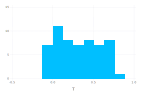

In [4]:
# Traçage de la distribution empirique de l'anomalie de température

plot(data, x=:T, Geom.histogram(bincount=round(sqrt(n))))

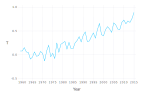

In [5]:
# Traçage de l'anomalie de température en fonction des années

fig1 = plot(data, x=:Year, y=:T, Geom.line, Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=collect(1960:5:2015))) 


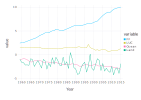

In [6]:
# Traçage des composantes du cycle du carbone en fonction des années

fig2 = plot(stack(data, [:FF, :LUC, :Ocean, :Land]), x=:Year, y=:value, color=:variable, Geom.line, Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=collect(1960:5:2015)) )


# Modèle de régression linéaire simple (section 2.1)

Pour commencer, on utilise seulement les émissions par combustion de combustibles fossibles 
comme variable explicative.

## Estimation des paramètres du modèle de régression linéaire simple

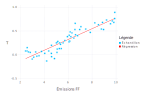

In [7]:
# taille de l'échantillon
n = length(Y)

x̄ = mean(X₁)
ȳ = mean(Y)

# Estimation des paramètres

β̂₁ = sum( (X₁[i] - x̄)*(Y[i] - ȳ) for i=1:n) / sum( (X₁[i] - x̄)^2 for i=1:n )

β̂₀ = ȳ - β̂₁*x̄


# Affichage de la droite de régression et des points observés

sample = layer( x=X₁, y=Y, Geom.point, Theme(default_color="deepskyblue"))
xx = collect(range(minimum(X₁),stop=maximum(X₁),length=10))
regression = layer(x=xx, y = β̂₀ .+ β̂₁*xx, Geom.line, Theme(default_color="red"))

plot(sample,regression ,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=2,xmax=10), Guide.xlabel("Émissions FF"), Guide.ylabel("T"))


# Modèle de régression linéaire multiple (section 2.2)

Dans cette section, toutes les variables explicatives sont utilisées pour expliquer les anomalies de température.

## Estimation des paramètres du modèle de régression

In [8]:
# taille de l'échantillon
n = length(Y)

# Construction de la matrice de structure
X = hcat(ones(n),X₁,X₂,X₃,X₄)

# Estimation des paramètres du modèle de régression
β̂ = (X'X)\X'Y

5-element Array{Float64,1}:
 -0.5973852647803128 
  0.171106940899803  
  0.18789865318566154
  0.13484499901704466
  0.04406430037649416

## Estimation de la variance de l'erreur

In [9]:
# Nb de variables explicatives
p = size(X,2)-1

# Calcul des résidus
e = Y-X*β̂

# Estimation de la variance de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )
println("σ̂² = $σ̂²")

σ̂² = 0.009939913109308664


## Validation des hypothèses de la régression linéaire

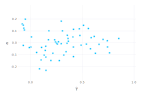

In [10]:
# Affichage des résidus

# Calcul de l'estimation
Ŷ = X*β̂

# Calcul des résidus
e = Y .- Ŷ

df = DataFrame(Ŷ = Ŷ, e = e)

plot(df, x = :Ŷ, y = :e, Geom.point, Coord.Cartesian(xmin=-.1,xmax=1,ymin=-.3,ymax=.3))


# TRAVAUX FUTURS

Utilisons uniquement comme variable explicative le quantité de carbone émise dans l'atmosphère par la combustion de combustibles fossiles afin de pouvoir tracer des graphiques intéressants. En plusieurs dimensions, l'affichage des résultats est beaucoup plus compliqué.

Bien que ce soit un problème de régression linéaire simple lorsque nous utilisons une seule variables explicative, nous pouvons utiliser la théorie de la régression linéaire multiple. 

## Estimation du modèle de régression avec une seule variable explicative 

In [ ]:
# taille de l'échantillon
n = length(Y)

# Construction de la matrice de structure
X = hcat(ones(n),X₁)

# Estimation des paramètres du modèle de régression
β̂ = (X'X)\X'Y

In [ ]:
# 2.2.2 Estimation de la variance de l'erreur

# Nb de variables explicatives
p = size(X,2)-1

# Calcul des résidus
e = Y-X*β̂

# Estimation de la variance de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )
println("σ̂² = $σ̂²")


In [ ]:
# Affichage de l'intervalle de prévision (NE FONCTIONNE PAS)

xx = collect( range(minimum(X₁),stop=maximum(X₁), length=100 ) ) 
xx = collect(0:.1:12)


borne_inf = similar(xx)
borne_sup = similar(xx)

t = quantile(TDist(n-p-1),.975)

τ² = similar(xx)

for i=1:n

    x₀ = [1,xx[i]]
    τ²[i] = σ̂²*(1 + x₀'/(X'*X)*x₀)
    
end

β̂₀ = β̂[1]
β̂₁ = β̂[2]

Ŷ = β̂₀ .+ xx*β̂₁

borne_inf = Ŷ .+ sqrt.(τ²)*quantile(TDist(n-p-1),.025)
borne_sup = Ŷ .+ sqrt.(τ²)*quantile(TDist(n-p-1),.975)

# for i =1:n
    
#     x₀ = [1,xx[i]]
#     Ŷ₀ = x₀'*β̂
    
#     borne_inf[i] = Ŷ₀-t*sqrt(σ̂²*(1 + x₀'/(X'*X)*x₀))
#     borne_sup[i] = Ŷ₀+t*sqrt(σ̂²*(1 + x₀'/(X'*X)*x₀)) 
    
# end

sample = layer( x=X₁, y=Y, Geom.point, Theme(default_color="deepskyblue"))
regression = layer(x=xx, y = β̂₀ .+ β̂₁*xx, Geom.line, Theme(default_color="red"))
int_inf = layer(x=xx, y = borne_inf, Geom.line, Theme(default_color="red"))
int_sup = layer(x=xx, y = borne_sup, Geom.line, Theme(default_color="red"))

plot(sample,regression,int_inf,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=0,xmax=12), Guide.xlabel("Émissions FF"), Guide.ylabel("T"))



In [ ]:
# 4.2.3 Prévision de Y pour un x donné

# Si en 2020 on émet 8 Gt C, quelle est l'anomalie de température attendue ? 

# L'estimation ponctuelle est la suivante
x₀ = [1 8]
Ŷ₀ = x₀*β̂
println("Si on émet 8 Gt C, on s'attend à une anomalie de température de $Ŷ₀")


## 4.3 Validation des hypothèses de la régression

In [ ]:
#= Ici, puisque nous somme dans le cas de la régression linéaire simple, 
on peut superposer le nuage de poaint à la droite de régression comme on l'a fait à la 
section précédente. Toutefois, nous examinerons les résidus de la régression, qui la méthode
plus générale pour la régression linéaire multiple. =#

Ŷ = X*β̂
e = Y - Ŷ
plot(x=Ŷ, y=e, Geom.point)

#= Ici les résidus sont centrés autour de 0 et semble avoir une variance plutôt constante.
    Toutefois, la forme des résidus est un peu embêtante, on aimerait avoir une forme plus
    rectangulaire. On verra plus tard si l'ajout de variables explicatives améliore permet
    d'obtenir ce rectangle. =#

## 4.6 Tests d'hypothèses et intervalles de confiance

On utilise le seuil de 5% par défaut.

In [ ]:
# 4.6.1 Est-ce que la régression avec X₁ est significative ?

SST = sum( (Y .- mean(Y)).^2)
SSE = sum( (Y .- X*β̂).^2 )
SSR = SST - SSE

F₀ = (SSR/1) / (SSE/(n-1-1)) 

# On rejette H₀ au seuil de 5% si la valeur-p associé à F₀ est plus petite que 5%
valeurp = ccdf(FDist(1,55),F₀)
println("Comme la valeur-p = $valeurp<0.05, on rejette H_0.")
println("La régression est donc significative.")

# Calcul du coefficient de détermination
R² = SSR/SST
println("Le coefficient de détermination est R² = $R²")

In [ ]:
# 4.6.2 Intervalles de confiance sur les coefficients de régression

C = inv(X'*X)
t = quantile(TDist(n-p-1),.975)

IC = [β̂-t*sqrt.(σ̂²*diag(C)) β̂+t*sqrt.(σ̂²*diag(C))]

println("β̂₀ = $(β̂[1]), $(IC[1,:])")
println("β̂₁ = $(β̂[2]), $(IC[2,:])")

In [ ]:
# 4.6.3 Intervalle de confiance sur la prévision

# Si en 2020 on émet 8 Gt C, quelle est l'anomalie de température attendue ? 

# L'estimation ponctuelle est la suivante
x₀ = [1 8]
Ŷ₀ = x₀*β̂

t = quantile(TDist(n-p-1),.975)

IC = [Ŷ₀-t*sqrt.(σ̂²*(1 .+ x₀/(X'*X)*x₀')) Ŷ₀+t*sqrt.(σ̂²*(1 .+ x₀/(X'*X)*x₀'))]

println("Si on émet 8 Gt C, on s'attend à une anomalie de température de $Ŷ₀, $IC.")


## On peut reproduire tous les résultats avec le package GLM

In [ ]:
# Estimons les paramètres du modèle avec le package GLM

M₁ = lm(@formula(T ~ FF), data)
x₀ = [1 8]
Ŷ₀ = predict(M₁,x₀)
println("Si on émet 8 Gt C, on s'attend à une anomalie de température de $Ŷ₀")
e = residuals(M₁)
R² = 1 - sum(e.^2)/SST
println("Le coefficient de détermination est $R²")

# 4.7 Comparaison de modèles (Partie 1)

Dans cette première partie, tentons de trouver la variable expicative qui a le plus grand pouvoir prédictif sur Y. On doit donc comparer 4 modèles de régression linéaire simple. Nous les comparerons avec le coefficient de détermination et le coefficient de détermination.

In [ ]:
M₁ = lm(@formula(T ~ FF), data)
M₂ = lm(@formula(T ~ LUC), data)
M₃ = lm(@formula(T ~ Ocean), data)
M₄ = lm(@formula(T ~ Land), data)

R² = zeros(4);

e = residuals(M₁)
R²[1] =  1 - sum(e.^2)/SST
e = residuals(M₂)
R²[2] =  1 - sum(e.^2)/SST
e = residuals(M₃)
R²[3] =  1 - sum(e.^2)/SST
e = residuals(M₄)
R²[4] =  1 - sum(e.^2)/SST

m = findmax(R²)
println("Le meilleur modèle est le modèle $(m[2]) avec un R² de $(m[1])")

# 4.7 Comparaison de modèles (Partie 2)

Dans cette première partie, tentons de trouver les variables explicatives qui ont le meilleur pouvoir prédictif sur Y. On doit comparer une collection de modèles de différentes dimensions avec le coefficient de détermination ajusté.

In [ ]:
M₁ = lm(@formula(T ~ FF), data)
M₂ = lm(@formula(T ~ FF + Ocean), data)
M₃ = lm(@formula(T ~ FF + Ocean + LUC), data)
M₄ = lm(@formula(T ~ FF + Ocean + LUC + Land), data)

R² = zeros(4);

# Pour le modèle M₁
p = length(coef(M₁))-1
e = residuals(M₁)
SSE = sum(e.^2)
R²[1] =  1 - SSE/SST * (n-1)/(n-p)

# Pour le modèle M₂
p = length(coef(M₂))-1
e = residuals(M₂)
SSE = sum(e.^2)
R²[2] =  1 - SSE/SST * (n-1)/(n-p)

# Pour le modèle M₃
p = length(coef(M₃))-1
e = residuals(M₃)
SSE = sum(e.^2)
R²[3] =  1 - SSE/SST * (n-1)/(n-p)

# Pour le modèle M₄
p = length(coef(M₄))-1
e = residuals(M₄)
SSE = sum(e.^2)
R²[4] =  1 - SSE/SST * (n-1)/(n-p)

m = findmax(R²)
println("Le meilleur modèle est le modèle $(m[2]) avec un R² ajusté de $(m[1])")


In [ ]:
# Analyse des résidus du meilleur modèle trouvé à la section précédente

X = [ones(n) X₁ X₂ X₃ X₄]
Ŷ = predict(M₄,X)
e = residuals(M₄)

plot(x=Ŷ, y=e, Geom.point, Coord.Cartesian(ymin=-.3,ymax=.3))